In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

In [2]:
from modules.infererence.preprocessing import *
from modules.infererence.object_detection import Model
from modules.infererence.nms import filter
import matplotlib.pyplot as plt
import cv2
import zipfile
import numpy as np

In [3]:
# Load all imanges from logistics.zip
zip_file_path = os.path.join('..', 'logistics.zip')
images, image_names = load_images_from_zip(zip_file_path)

In [15]:
# load txt file in the logistics.zip for ground truth
ground_truths = {}

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    ground_truth_files = [f for f in zip_ref.namelist() if f.endswith('.txt')]

    for file_name in ground_truth_files:
        with zip_ref.open(file_name) as file:
            image_name, _ = os.path.splitext(file_name)
            ground_truths[image_name] = load_ground_truth(file)

# Example print
print(ground_truths['4SqU3XHULjsH1J07w8FjZHpwQnY42a56WDL_4a7kZBjX_owoZkPihoYgMfWybV6xQ4bm8JdP599yg6k5fX6lMZzu_jpg.rf.564d126df55c75aa59bd0c50e6cadee9'])

[[0.5, 0.525, 1.0, 0.54375, 6.0]]


In [14]:
image_name_to_check = "4SqU3XHULjsH1J07w8FjZHpwQnY42a56WDL_4a7kZBjX_owoZkPihoYgMfWybV6xQ4bm8JdP599yg6k5fX6lMZzu_jpg.rf.564d126df55c75aa59bd0c50e6cadee9"

if image_name_to_check in image_names:
    print(f"{image_name_to_check} is in the image name list.")
else:
    print(f"{image_name_to_check} is not in the image name list.")

4SqU3XHULjsH1J07w8FjZHpwQnY42a56WDL_4a7kZBjX_owoZkPihoYgMfWybV6xQ4bm8JdP599yg6k5fX6lMZzu_jpg.rf.564d126df55c75aa59bd0c50e6cadee9 is in the image name list.


In [5]:
# Define IoU (Intersection over Union) for model comparison metric
def calculate_iou(box1, box2):
    # Convert [x_center, y_center, width, height] to [x1, y1, x2, y2]
    box1_x1 = box1[0] - box1[2] / 2
    box1_y1 = box1[1] - box1[3] / 2
    box1_x2 = box1[0] + box1[2] / 2
    box1_y2 = box1[1] + box1[3] / 2
    
    box2_x1 = box2[0] - box2[2] / 2
    box2_y1 = box2[1] - box2[3] / 2
    box2_x2 = box2[0] + box2[2] / 2
    box2_y2 = box2[1] + box2[3] / 2
    
    # Calculate the intersection
    inter_x1 = max(box1_x1, box2_x1)
    inter_y1 = max(box1_y1, box2_y1)
    inter_x2 = min(box1_x2, box2_x2)
    inter_y2 = min(box1_y2, box2_y2)
    
    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    
    # Calculate the union
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    
    union_area = box1_area + box2_area - inter_area
    
    # Calculate IoU
    if union_area == 0:
        return 0
    iou = inter_area / union_area
    return iou

In [6]:
# Apply the Model for predictions
def get_prediction(images, image_names, yolo_model, ground_truths, iou_threshold=0.5):
    predictions = {}

    for image, image_name in zip(images, image_names):
        # Process the image
        image_resized = cv2.resize(image, (416, 416))
        
        # Get predictions, apply nms filter
        image_prediction = yolo_model.predict(image_resized)
        bboxes, class_ids, scores = yolo_model.post_process(image_prediction, score_threshold=0.5)
        filtered_bboxes, filtered_class_ids, filtered_scores = filter(bboxes, class_ids, scores, nms_iou_threshold=0.8)

        # Save predictions for this image
        predictions[image_name] = (filtered_bboxes, filtered_class_ids, filtered_scores)
    
    return predictions


In [7]:
# Evaluate the performance of the model by calculating IoU for each prediction
def evaluate_model(predictions, ground_truths, iou_threshold=0.5):
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0
    total_iou = 0
    total_detected = 0
    precision_recall_points = {}

    for image_name, prediction in predictions.items():
        # Get predicted box
        filtered_bboxes, filtered_class_ids, filtered_scores = prediction
        # Get ground truth box
        ground_truth_bboxes = ground_truths.get(image_name, [])
        
        matched_ground_truths = set()

        for pred_bbox, pred_class_id, pred_score in zip(filtered_bboxes, filtered_class_ids, filtered_scores):
            pred_class_id = int(pred_class_id)
            found_match = False
            
            for i, gt_bbox in enumerate(ground_truth_bboxes):
                gt_class_id = gt_bbox[-1]
                if pred_class_id == gt_class_id:
                    iou = calculate_iou(pred_bbox, gt_bbox[:-1])
                    if iou >= iou_threshold:
                        found_match = True
                        matched_ground_truths.add(i)
                        total_true_positives += 1
                        total_iou += iou
                        total_detected += 1
                        if pred_class_id not in precision_recall_points:
                            precision_recall_points[pred_class_id] = []
                        precision_recall_points[pred_class_id].append((iou, pred_score))
                        break
            
            if not found_match:
                total_false_positives += 1
                precision_recall_points[pred_class_id] = []
                precision_recall_points[pred_class_id].append((0, pred_score))

        # Count false negatives (missed ground truth boxes)
        total_false_negatives += len(ground_truth_bboxes) - len(matched_ground_truths)

    precision = total_true_positives / (total_true_positives + total_false_positives + 1e-5)
    recall = total_true_positives / (total_true_positives + total_false_negatives + 1e-5)
    mean_iou = total_iou / (total_detected + 1e-5)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Mean IoU: {mean_iou:.4f}")

    return precision, recall, mean_iou, precision_recall_points

In [8]:
# Calculate mean average precision
def calculate_map(precision_recall_points, num_classes):
    mean_average_precisions = []
    ap_per_class = {}

    for class_id in range(num_classes):
        points = precision_recall_points.get(class_id, [])
        if not points:
            mean_ap = 0
        else:
            # Sort by recall in descending order
            points = sorted(points, key=lambda x: x[0], reverse=True)

            interpolated_precisions = []
            for recall_threshold in [j * 0.1 for j in range(11)]:
                # Find all precisions meet the recall_threshold
                possible_precisions = [p for r, p in points if r >= recall_threshold]
                if possible_precisions:
                    interpolated_precisions.append(max(possible_precisions))
                else:
                    interpolated_precisions.append(0)

            # Average precision for this class
            mean_ap = sum(interpolated_precisions) / len(interpolated_precisions)

        # Store the AP for this class
        ap_per_class[class_id] = mean_ap
        mean_average_precisions.append(mean_ap)

    # Calculate overall map
    overall_map = sum(mean_average_precisions) / num_classes
    
    print(f"Mean Average Precision: {overall_map:.4f}")
    
    return overall_map, ap_per_class


In [9]:
# Function to load class names
def load_class_names(names_file):
    with open(names_file, 'r') as f:
        class_names = [line.strip() for line in f.readlines()]
    return class_names

In [10]:
# Function to plot per-class AP for two models using actual class names
def plot_map_per_class(ap_per_class_1, ap_per_class_2, class_names):
    num_classes = len(class_names)

    # Extract the AP values for both models
    ap_values_1 = [ap_per_class_1.get(i, 0) for i in range(num_classes)]
    ap_values_2 = [ap_per_class_2.get(i, 0) for i in range(num_classes)]

    bar_width = 0.35
    index = np.arange(num_classes)

    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot for Model 1
    bars1 = ax.bar(index, ap_values_1, bar_width, label='YOLO Model 1', color='b')
    # Plot for Model 2
    bars2 = ax.bar(index + bar_width, ap_values_2, bar_width, label='YOLO Model 2', color='r')

    ax.set_xlabel('Class')
    ax.set_ylabel('Average Precision (AP)')
    ax.set_title('Per-Class Average Precision (AP) for YOLO Models')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()

    # Annotate the bars with their AP values
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', 
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # Offset text above the bar
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

## Performance of YOLO Model 1

In [11]:
yolo_version = 1

yolo_model_folder = f'yolo_model_{yolo_version}'
# Paths to the extracted files
model_config = os.path.join('..', f'yolo_model_{yolo_version}', f'yolov4-tiny-logistics_size_416_{yolo_version}.cfg')
model_weights = os.path.join('..', f'yolo_model_{yolo_version}', f'yolov4-tiny-logistics_size_416_{yolo_version}.weights')
class_names = os.path.join('..', f'yolo_model_{yolo_version}', 'logistics.names')

yolo_model_1 = Model(model_config, model_weights, class_names)

predictions_1 = get_prediction(images, image_names, yolo_model_1, ground_truths, iou_threshold=0.8)


KeyboardInterrupt: 

In [12]:
print("Evaluating YOLO Model 1")
precision_1, recall_1, mean_iou_1, precision_recall_points_1 = evaluate_model(predictions_1, ground_truths, iou_threshold=0.6)
overall_map_1, ap_per_class_1 = calculate_map(precision_recall_points_1, num_classes=20)

Evaluating YOLO Model 1
Precision: 0.7265
Recall: 0.4086
Mean IoU: 0.7919
Mean Average Precision: 0.4512


## Performance of YOLO Model 2

In [13]:
yolo_version = 2

yolo_model_folder = f'yolo_model_{yolo_version}'
# Paths to the extracted files
model_config = os.path.join('..', f'yolo_model_{yolo_version}', f'yolov4-tiny-logistics_size_416_{yolo_version}.cfg')
model_weights = os.path.join('..', f'yolo_model_{yolo_version}', f'yolov4-tiny-logistics_size_416_{yolo_version}.weights')
class_names = os.path.join('..', f'yolo_model_{yolo_version}', 'logistics.names')

yolo_model_2 = Model(model_config, model_weights, class_names)

predictions_2 = get_prediction(images, image_names, yolo_model_2, ground_truths, iou_threshold=0.8)

In [14]:
print("Evaluating YOLO Model 2")
precision_2, recall_2, mean_iou_2, precision_recall_points_2 = evaluate_model(predictions_2, ground_truths, iou_threshold=0.6)
overall_map_2, ap_per_class_2 = calculate_map(precision_recall_points_2, num_classes=20)

Evaluating YOLO Model 2
Precision: 0.7639
Recall: 0.4836
Mean IoU: 0.7910
Mean Average Precision: 0.3864


In [15]:
# Load class names for plotting
class_names_content = load_class_names(class_names)

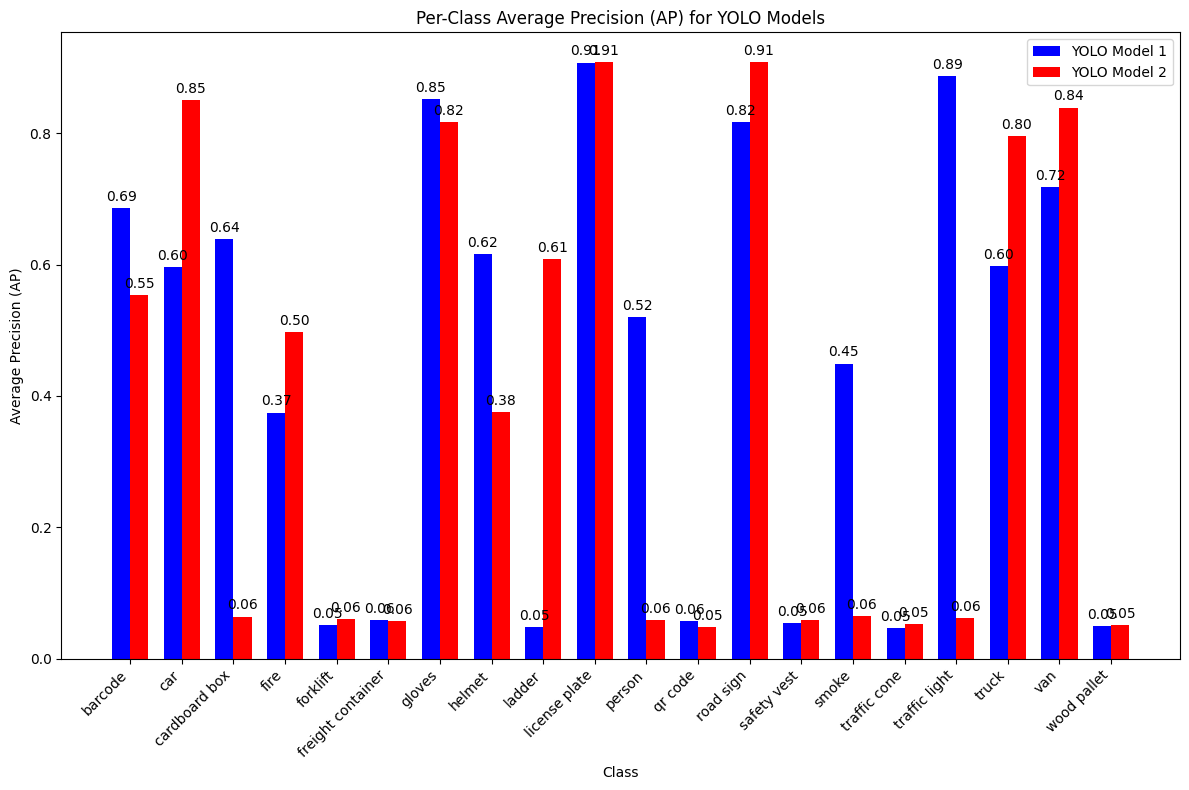

In [16]:
plot_map_per_class(ap_per_class_1, ap_per_class_2, class_names_content)

**Precision:** measures the proportion of correct positive detections out of all detections made by the model. Model 2 has a slightly higher precision (0.7639) compared to Model 1 (0.7265). This indicates that Model 2 is slightly better at making accurate detections.

**Recall:** measures how many of the true objects were detected by the model. Model 2 again has a higher recall (0.4836) compared to Model 1 (0.4086). This suggests that Model 2 is slightly better at identifying more objects in the image.

**Mean IoU:** measures how well the predicted bounding boxes overlap with the ground truth bounding boxes. It is almost the same for both models (Model 1: 0.7919, Model 2: 0.7910). They both localize the objects with a similar level of accuracy.

**Mean Average Precision (MAP):** captures both precision and recall across multiple thresholds. Model 1 has a higher mAP (0.4512) compared to Model 2 (0.3864). The MAP score suggests that Model 1 performs better overall in detecting objects across all confidence thresholds, despite having slightly lower precision and recall.

**Per-Class AP Comparison:** Model 1 dominates in certain critical classes like "gloves", "safety vest", and "person", where accurate detection might be more important in certain logistics applications (e.g., detecting safety equipment). Model 2 outperforms Model 1 in other classes like "cardboard box", "truck", and "van", which might be more important in tasks related to vehicle and package detection. 

In general, the choice of the model ultimately depends on the specific requirements of the application and the importance of certain object classes. if the objective is to achieve better overall performance and stronger detection in categories like safety equipment, YOLO Model 1 should be chosen.